In [1]:
#First importing the libs
from os.path import exists
import torch
from __future__ import print_function, division
%matplotlib inline
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt
import time
import os
import json
import copy
from torch.autograd import Variable
import datetime
import requests
import io
from io import BytesIO

plt.ion() 
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('CUDA is available, Training on GPU ...')
else:
    print('CUDA is not available!  Training on CPU ...')

CUDA is available, Training on GPU ...


In [2]:
#Remove the old folder to prevent duplicating
#Redownloading the dataset
!rm -r flower_data
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip -qq flower_data.zip
#Creating Test directory and print images numbers
!mkdir flower_data/test
!cp -a flower_data/valid/. flower_data/test
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
!ls flower_data/test
print("Finished importing dataset")

1    12  18  23  29  34  4   45  50  56  61  67  72  78  83  89  94
10   13  19  24  3   35  40  46  51  57  62  68  73  79  84  9	 95
100  14  2   25  30  36  41  47  52  58  63  69  74  8	 85  90  96
101  15  20  26  31  37  42  48  53  59  64  7	 75  80  86  91  97
102  16  21  27  32  38  43  49  54  6	 65  70  76  81  87  92  98
11   17  22  28  33  39  44  5	 55  60  66  71  77  82  88  93  99
Finished importing dataset


In [0]:
#Create Transforms
tra_training = transforms.Compose([
                                          transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomVerticalFlip(p=0.2),
                                          transforms.RandomHorizontalFlip(p=0.2),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.485, 0.456, 0.406),
                                                               (0.229, 0.224, 0.225))
                                         ])


tra_validation = transforms.Compose([
                                            transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.485, 0.456, 0.406),
                                                                 (0.229, 0.224, 0.225))
                                           ])

tra_testing = transforms.Compose([
                                         transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.485, 0.456, 0.406),
                                                              (0.229, 0.224, 0.225))
                                        ])
training_batch = 64
validation_testing_batch = 32

# TODO: Load the datasets with ImageFolder
dataset_training = torchvision.datasets.ImageFolder(train_dir, transform = tra_training)
dataset_validation = torchvision.datasets.ImageFolder(valid_dir, transform = tra_validation)
dataset_testing = torchvision.datasets.ImageFolder(test_dir, transform = tra_testing)


# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloader_training = torch.utils.data.DataLoader(dataset_training, batch_size=training_batch, shuffle=True, drop_last=True)
dataloader_validation = torch.utils.data.DataLoader(dataset_validation, batch_size=validation_testing_batch)
dataloader_testing = torch.utils.data.DataLoader(dataset_testing, batch_size=validation_testing_batch)


In [0]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
###Define Validation method
def validation(model, dataloader_validation, criterion):
    valid_correct = 0
    valid_loss = 0

    for images_input, labels in (iter(dataloader_validation)):
        images_input, labels = images_input.to('cuda'), labels.to('cuda')

        # Forward pass
        output = model.forward(images_input)
        loss = criterion(output, labels)

        # Track loss
        valid_loss += loss.item()
        _, output_v = torch.max(output.data, 1)

        # Track Accuracy
        valid_correct += (output_v == labels).sum()
    
    return valid_loss/len(dataloader_validation), (100*valid_correct)/(validation_testing_batch*len(dataloader_validation))


In [6]:
# we need pillow version 5.3.0 or above
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==6.1.0
# import the new one
import PIL
print("Finished instaling Pillow version",PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime
####################################################

Uninstalling Pillow-6.1.0:
  Successfully uninstalled Pillow-6.1.0
  Using cached https://files.pythonhosted.org/packages/14/41/db6dec65ddbc176a59b89485e8cc136a433ed9c6397b6bfe2cd38412051e/Pillow-6.1.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


Finished instaling Pillow version 6.1.0


In [7]:
model = models.vgg19(pretrained=True)

for param in model.parameters():
    param.requires_grad = False 
    
# Setup
input_size = 25088
output_size = 102
hidden_sizes = [1024, 256]
EPOCHS = 100
LR = 0.0001

# Define Classifier
classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(input_size, hidden_sizes[0])),
            ('relu1', nn.ReLU()),
            ('drop1', nn.Dropout(p=0.5)),
            ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
            ('relu2', nn.ReLU()),
            ('fc3', nn.Linear(hidden_sizes[1], output_size)),
            ('output', nn.LogSoftmax(dim=1))]))

# classifier needs to be assigned to the model before moving it to GPU
model.classifier = classifier

# Move model to GPU
model.to('cuda')

# Optimizer should defined after moving model to GPU
optimizer = optim.Adam(model.classifier.parameters(), lr=LR)
criterion = nn.NLLLoss()

model.train()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:09<00:00, 62085312.21it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [8]:
for e in range(EPOCHS):
    start = datetime.datetime.now()
    printStep = 4
    training_loss = 0
    training_corr = 0
    steps = 0
    print_every = 25

    for images_input, labels in iter(dataloader_training):
        # Setup
        steps += 3
        images_input, labels = images_input.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()

        # Forward and backward passes
        output = model.forward(images_input)       
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # Track loss
        ## loss contains loss value and the grad_fn, when loss.item() contains only the value.
        training_loss += loss.item() 

        # Track accuracy
        ## output contains the output and the grad_fn, when output.data contains only the output.
        _, output_t = torch.max(output.data, 1)
        training_corr += (output_t == labels).sum()

        if(steps % print_every == 0):
            model.eval()
            
            with torch.no_grad():
                validation_loss, validation_accu = validation(model, dataloader_validation, criterion)
                if ( printStep % 4 == 0):
                  print("Epoch:{}/{} ".format(e + 1, EPOCHS),
                      "Training Loss: {:.3f} ".format(training_loss/print_every),
                      "Training Accu: {:.3f}% ".format((100*training_corr)/(print_every*training_batch)),
                      "Validation Loss: {:.3f} ".format(validation_loss),
                      "Validation Accu: {:.3f}%".format(validation_accu))
                  printStep +=1
            training_loss = 0
            training_corr = 0
            
            model.train()

    end = datetime.datetime.now()
    total_duration = end - start
    print('#Total time spent in this epoch to train the model: {} mins'.format(total_duration.total_seconds()/60))

Epoch:1/100  Training Loss: 4.484  Training Accu: 5.000%  Validation Loss: 4.157  Validation Accu: 7.000%
#Total time spent in this epoch to train the model: 3.0605302 mins
Epoch:2/100  Training Loss: 2.682  Training Accu: 40.000%  Validation Loss: 2.011  Validation Accu: 51.000%
#Total time spent in this epoch to train the model: 3.0678003833333336 mins
Epoch:3/100  Training Loss: 1.834  Training Accu: 55.000%  Validation Loss: 1.237  Validation Accu: 68.000%
#Total time spent in this epoch to train the model: 3.0610394333333333 mins
Epoch:4/100  Training Loss: 1.476  Training Accu: 62.000%  Validation Loss: 0.848  Validation Accu: 79.000%
#Total time spent in this epoch to train the model: 3.0601165166666666 mins
Epoch:5/100  Training Loss: 1.224  Training Accu: 68.000%  Validation Loss: 0.718  Validation Accu: 81.000%
#Total time spent in this epoch to train the model: 3.0623708333333335 mins
Epoch:6/100  Training Loss: 1.102  Training Accu: 72.000%  Validation Loss: 0.577  Validati

In [9]:
def testing(model, dataloader_testing, criterion):
    testing_correct = 0
    testing_loss = 0
    
    start = datetime.datetime.now()
    model.eval()
    
    for images_input, labels in (iter(dataloader_testing)):
        images_input, labels = images_input.to('cuda'), labels.to('cuda')

        # Forward pass
        output = model.forward(images_input)
        loss = criterion(output, labels)

        # Track loss
        testing_loss += loss.item()
        _, output_t = torch.max(output.data, 1)

        # Track Accuracy
        testing_correct += (output_t == labels).sum()

    model.train()
    
    end = datetime.datetime.now()
    total_duration = end - start
    print('Total time spent to test the model: {} mins'.format(total_duration.total_seconds()/60))
    
    return testing_loss/len(dataloader_testing), (100*testing_correct)/(validation_testing_batch*len(dataloader_testing))

testing_loss, testing_accu = testing(model, dataloader_testing, criterion)
print("Testing Loss: {:.3f} ".format(testing_loss), "Testing Accu: {:.3f}%".format(testing_accu))

Total time spent to test the model: 0.2557975 mins
Testing Loss: 0.249  Testing Accu: 92.000%


In [0]:
training_batch = 64
arch = models.vgg19
validation_testing_batch = 32
savedata = {
            'model_state': model.state_dict(),
            'criterion_state': criterion.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'classifier': classifier,
            'class_to_idx': dataset_training.class_to_idx,
            'epochs': EPOCHS,
            'arch': arch,
            'lr':LR,
            'training_batch':training_batch,
            'validation_testing_batch':validation_testing_batch
           }

torch.save(savedata, 'trained_model.pth')

In [0]:
def load_previous_model(filename):
    loaddata = torch.load(filename)
    arch = "vgg19"
    #model_fn = getattr(torchvision.models, loaddata['arch'])
    #model = model_fn()
    model.classifier = loaddata['classifier']
    model.to('cuda')
    model.class_to_idx = loaddata['class_to_idx']
    model.load_state_dict(loaddata['model_state'])
    
    LR = loaddata['lr']

    optimizer = optim.Adam(model.classifier.parameters(), lr=LR)
    optimizer.load_state_dict(loaddata['optimizer_state'])
    
    return model, optimizer;

model, optimizer = load_previous_model('trained_model.pth')


In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # scale
    img_w, img_h = image.size
    
    if(img_w > img_h):
        image = image.resize(size=(int((img_w*256)/img_h),256))
    elif(img_w < img_h):
        image = image.resize(size=(256,int((img_w*256)/img_h)))

    # crop
    img_w_new, img_h_new = image.size
    c1 = int(img_w_new/2-112)
    c2 = int(img_h_new/2-112)
    c3 = int(img_w_new/2+112)
    c4 = int(img_h_new/2+112)
    
    image = image.crop((c1, c2, c3, c4)) # Getting (224, 224) image
    
    # normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_array = np.array(image) / 255
    image_norm = (image_array - mean) / std
    
    # reorder dimension
    image_trans = image_norm.transpose((2,0,1))
    
    return torch.from_numpy(image_trans) # converting ndarray to tensor


In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


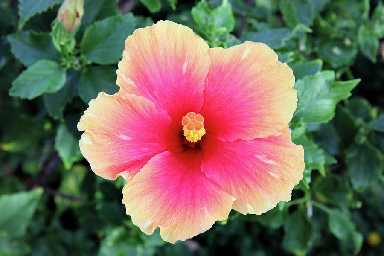

In [18]:
img_url = "https://images.fineartamerica.com/images-medium-large/maui-hibiscus-pierre-leclerc.jpg"
res = requests.get(img_url, stream=True)

if res.status_code == 200:
    img_pil = Image.open(io.BytesIO(res.content))

img_pil.resize(size=(int((img_pil.size[0]*256)/img_pil.size[1]),256))


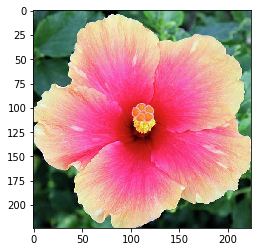

In [19]:
output = process_image(img_pil)
imshow(output)


In [0]:
def predict(model, image_path, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    output = process_image(image_path)
    output.unsqueeze_(0)
    output = output.cuda().float()
    
    model.eval()
    
    with torch.no_grad():
        score = model(output)
        prob, idxs = torch.topk(score, topk)
    
        # convert indices to classes
        idxs = idxs.cpu().numpy()

        idx_to_class = {val:key for key, val in model.class_to_idx.items()}
        classes = [idx_to_class[idx] for idx in idxs[0]]
        
        # map the class name with collected topk classes
        names = []
        for cls in classes:
            names.append(cat_to_name[str(cls)])
        
        return prob, names

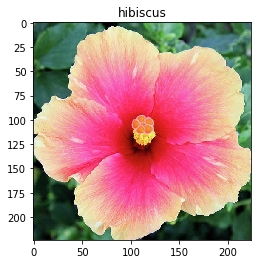

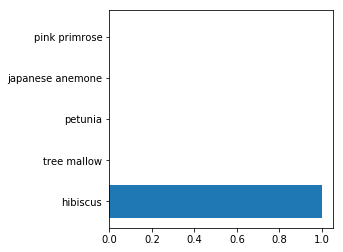

In [21]:
# TODO: Display an image along with the top 5 classes
x_pos, y_pos = predict(model, img_pil, topk=5)

ax_img = imshow(output)
ax_img.set_title(y_pos[0])

plt.figure(figsize=(4,4))
plt.barh(range(len(y_pos)), np.exp(x_pos[0].cpu().numpy()))
plt.yticks(range(len(y_pos)), y_pos)

plt.show()


In [22]:
#Coping the classifier to Udacity Workspace
###########################################
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Saving the as classifier.pt
model_save_name = 'classifier_10092019.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)